<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/OTIMOS_covid19_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cat /etc/issue

In [0]:
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

/bin/bash: conda: command not found


#Fazer




*   confuzin and matrix = print(classification_report())
*   SKLearning para avaliar, matrix confuzion e tals
*   Voltar para 3 classes
*   mudar para sgd
*   CheXnet
*   Arrumar imagens dataset covid
*   bin ou mult???
*   augmentation in train and val
*   testar sigmoid
*   binary crossentropy

***Mudar agora***
- Tratar com binário
- binary_crossentropy
- sigmopid na ultima

- testar 30,30,30
- mudar monitor[acc]





#Feito

*   ***inicialzar pesos do kernel em todos os modelos = top_model = Dense(1024,activation='relu', kernel_initializate='he_normal')(top_model)***
*   ***re-treinar as camadas das redes pre treinadas***
*   ***arrumar dropout 0.5***
*   ***dataimagegeneration***
*   ***ReduceLROnPlateau***
*   ***usar DenseNet121***
*   ***Mudar dataset para o do kaggle mais atual***

#Imports

In [0]:
version = '-v9-'

In [2]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

Using TensorFlow backend.


In [0]:
tf.__version__

'2.2.0'

#Download do dataset no kaggle

In [0]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

kaggle datasets download tawsifurrahman/covid19-radiography-database


100% 1.15G/1.15G [00:09<00:00, 125MB/s]
100% 1.15G/1.15G [00:09<00:00, 126MB/s]


In [0]:
!unzip '/content/drive/My Drive/UNICAMP/databases/covid19-radiography-database.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19/'

#Constantes

In [3]:
len_normal_train = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/train/normal')])
len_normal_val = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/val/normal')])
len_normal_test = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/test/normal')])

len_pneumonia_train = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/train/pneumonia')])
len_pneumonia_val = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/val/pneumonia')])
len_pneumonia_test = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/test/pneumonia')])

len_test_train = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/train/covid')])
len_test_val = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/val/covid')])
len_test_test = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/test/covid')])

#totais
len_train_total = len_normal_train + len_pneumonia_train + len_test_train
len_val_total = len_pneumonia_val + len_test_val + len_normal_val
len_test_total = len_normal_test + len_pneumonia_test + len_test_test

print("Totais parciais")
print("---------------------")
print ("normal no train: ", len_normal_train)
print ("normal no val: ", len_normal_val)
print ("normal no test: ", len_normal_test)
print("---------------------")
print ("pneumonia no train: ", len_pneumonia_train)
print ("pneumonia no val: ", len_pneumonia_val)
print ("pneumonia no test: ", len_pneumonia_test)
print("---------------------")
print ("covid no train: ", len_test_train)
print ("covid no val: ", len_test_val)
print ("covid no test: ", len_test_test)
print()
print("Totais")
print("---------------------")
print("total train: ", len_train_total)
print("total val: ", len_val_total)
print("total test: ", len_test_total)


Totais parciais
---------------------
normal no train:  842
normal no val:  214
normal no test:  280
---------------------
pneumonia no train:  874
pneumonia no val:  215
pneumonia no test:  256
---------------------
covid no train:  40
covid no val:  5
covid no test:  13

Totais
---------------------
total train:  1756
total val:  434
total test:  549


In [0]:
#parameters
num_classes = 3
img_rows, img_cols = 224, 224

epochs = 100
batch_size = 16

models_loss = 'binary_crossentropy'
models_opt = Adam(lr=0.001) #SGD(learning_rate=0.001, momentum=0.9) #ADAM(lr=0.001)

#Split dataset in train, test and *validation*

In [10]:
# Path to data
data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

# print("Datasets: {} - tamanho {}".format(os.listdir(data_dir), len(data_dir)))
# print("Imagens para treino: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train')])))
# print("Imagens para teste: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/test')])))
# print("Imagens para validação: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val')])))

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

# len_test_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/covid')])
# len_test_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/normal')])
# len_val_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/covid')])
# len_val_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/normal')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)


Files per classes
----------------------------------------
normal :  1341
pneumonia :  1345
covid :  58


In [0]:
#dataaug
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range = 0, 
                             height_shift_range = 0,  
                             shear_range=0, 
                             horizontal_flip = True,) 

imgs = os.listdir(normal_dir)

for img in imgs:
    img=cv2.imread(normal_dir+"/"+img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = r'/content/drive/My Drive/UNICAMP/databases/covid_aug2/normal', save_prefix ='aug', save_format='jpg'):
        i+=1
        if i>7:
            break

In [0]:
#dataaug
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range = 0, 
                             height_shift_range = 0,  
                             shear_range=0, 
                             horizontal_flip = True,)  

imgs = os.listdir(pneumonia_dir)

for img in imgs:
    img=cv2.imread(pneumonia_dir+"/"+img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = r'/content/drive/My Drive/UNICAMP/databases/covid_aug2/pneumonia', save_prefix ='aug', save_format='jpg'):
        i+=1
        if i>7:
            break

In [0]:
#dataaug
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range = 0, 
                             height_shift_range = 0,  
                             shear_range=0, 
                             horizontal_flip = True,) 

imgs = os.listdir(covid_dir)

for img in imgs:
    img=cv2.imread(covid_dir+"/"+img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = r'/content/drive/My Drive/UNICAMP/databases/covid_aug2/covid', save_prefix ='aug', save_format='jpg'):
        i+=1
        if i>80:
            break

In [11]:
print ("normal: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid_aug2/normal')]))
print ("pneu: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid_aug2/pneumonia')]))
print ("covid: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid_aug2/covid')]))

normal:  6575
pneu:  6574
covid:  453


In [0]:
# Path to data
!mkdir '/content/drive/My Drive/UNICAMP/databases/covid_aug2/covid/train'
!mkdir '/content/drive/My Drive/UNICAMP/databases/covid_aug2/covid/test'
!mkdir '/content/drive/My Drive/UNICAMP/databases/covid_aug2/covid/val'

data_dir = '/content/drive/My Drive/UNICAMP/databases/covid_aug2/covid'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

# print("Datasets: {} - tamanho {}".format(os.listdir(data_dir), len(data_dir)))
# print("Imagens para treino: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train')])))
# print("Imagens para teste: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/test')])))
# print("Imagens para validação: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val')])))

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

# len_test_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/covid')])
# len_test_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/normal')])
# len_val_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/covid')])
# len_val_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/normal')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)


In [0]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [0]:
#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
root = data_dir
normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

# random.shuffle(normal_xray)
# #random.shuffle(pneumonia_xray)
# random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/train' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/test' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/val' #remove a pasta se ela ja existir

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


#Data augmentation and DataGen

In [0]:
# #data augmentation
# train_datagen = ImageDataGenerator(samplewise_center=False,
#                                    samplewise_std_normalization=False,
#                                    brightness_range=[0.7, 1.5],
#                                    rescale=1./255,
#                                    rotation_range=30,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    horizontal_flip=True,
#                                    vertical_flip=False,
#                                    zoom_range=0.125,
#                                    shear_range=0.01,
#                                    fill_mode='nearest')

# #nao faz data aug
# validation_datagen = ImageDataGenerator(samplewise_center=False,
#                                         samplewise_std_normalization=False,
#                                         brightness_range=[0.7, 1.5],
#                                         rescale=1./255,
#                                         rotation_range=30,
#                                         width_shift_range=0.1,
#                                         height_shift_range=0.1,
#                                         horizontal_flip=True,
#                                         vertical_flip=False,
#                                         zoom_range=0.125,
#                                         shear_range=0.01,
#                                         fill_mode='nearest')

# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(img_rows, img_cols),
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical')

# validation_generator = validation_datagen.flow_from_directory(val_dir,
#                                                               target_size=(img_rows, img_cols),
#                                                               batch_size=batch_size,
#                                                               class_mode='categorical')

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_no_aug.flow_from_directory(
       directory = train_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = val_dir,
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator= data_generator_no_aug.flow_from_directory(
       directory = test_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')


Found 1756 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


#Visualizando algumas amostras dos datasets

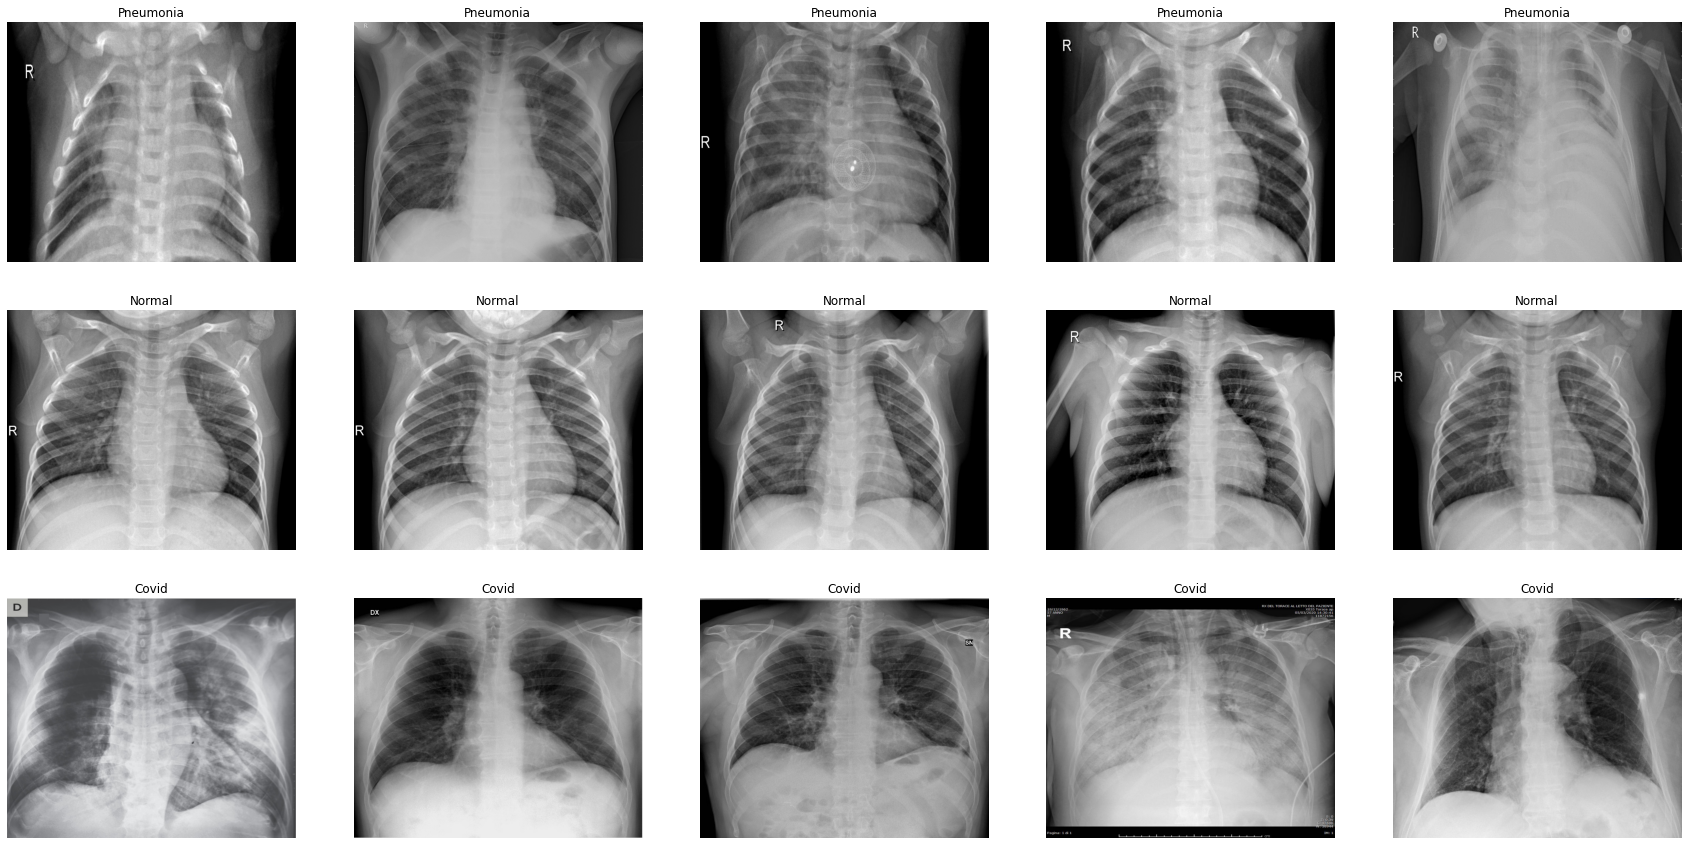

In [0]:
### VERIFICAR SE AS CLASSES ESTÃO CORRETAS

# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
covid_cases = glob(covid_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Modelos

##Nosso botton model

In [0]:
#criando o nosso top layer
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

#assim ficou horrivel
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)

##DenseNet201

74842112/74836368 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_25 (ZeroPadding2 (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_25[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

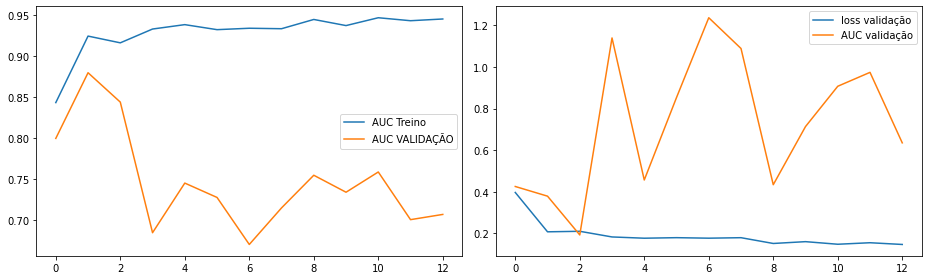

In [0]:
#DenseNet201
DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet201.layers:
  layer.trainable=False

FC = addTopModel(DenseNet201, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet201.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet201'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##DenseNet121

##teste 1 - 1 dense de 1024

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_29 (ZeroPadding2 (None, 230, 230, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_29[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

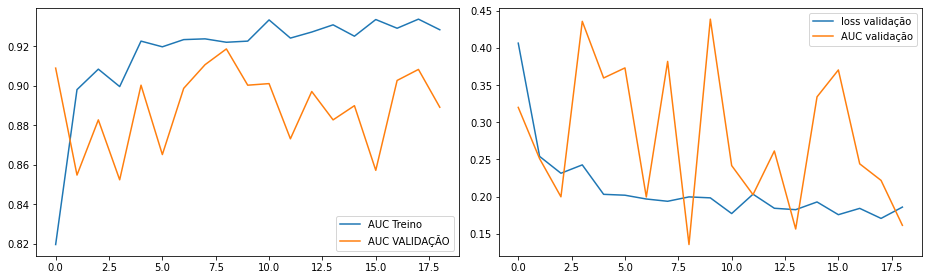

In [0]:
#DenseNet201

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)



%matplotlib inline

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##teste 2 - Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_31 (ZeroPadding2 (None, 230, 230, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

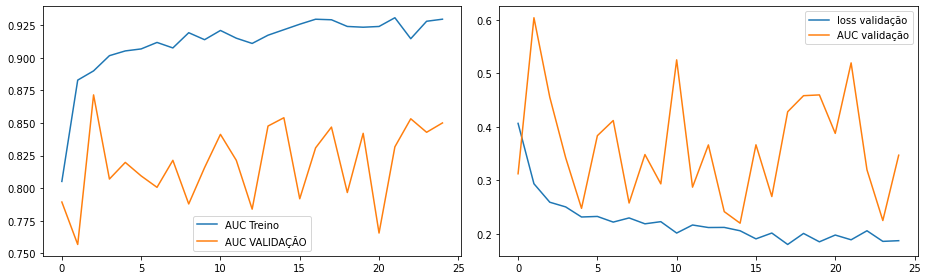

In [0]:
#DenseNet201
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##teste 3 - 6 dense decrescentes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

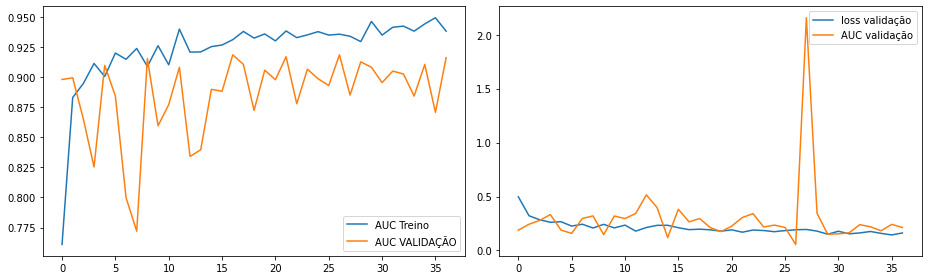

In [0]:
##### MELHOR
#109/109 [==============================] - 59s 545ms/step - loss: 0.1576 - accuracy: 0.9423 - val_loss: 0.1065 - val_accuracy: 0.9242

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 3b - 3 dense - ADAM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_17[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

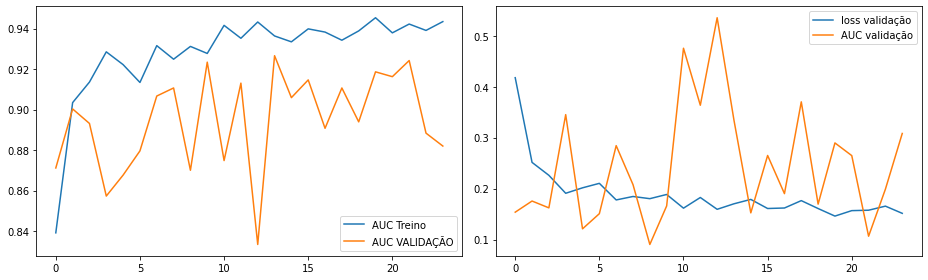

In [0]:
####### MELHOR
#109/109 [==============================] - 59s 545ms/step - loss: 0.1576 - accuracy: 0.9423 - val_loss: 0.1065 - val_accuracy: 0.9242

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 3c - 5 dense - com ADAM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

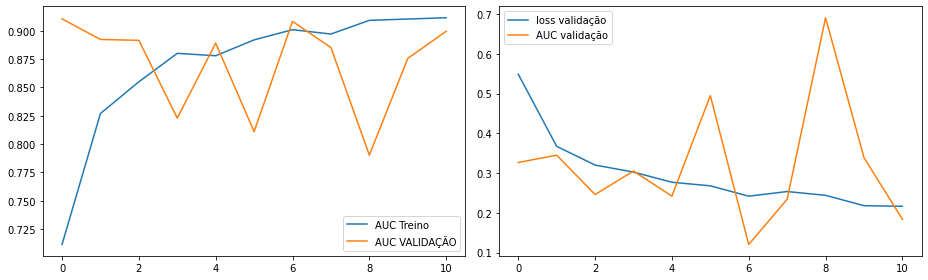

In [0]:
#melhores até agora neste modelo
#Epoch 98/100
#109/109 [==============================] - 59s 542ms/step - loss: 0.1392 - accuracy: 0.9486 - val_loss: 0.1121 - val_accuracy: 0.9196
#Epoch 99/100
#109/109 [==============================] - 59s 544ms/step - loss: 0.1247 - accuracy: 0.9547 - val_loss: 0.2072 - val_accuracy: 0.9377

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 5 - 6 dense decrescente - Com SGD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_21[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

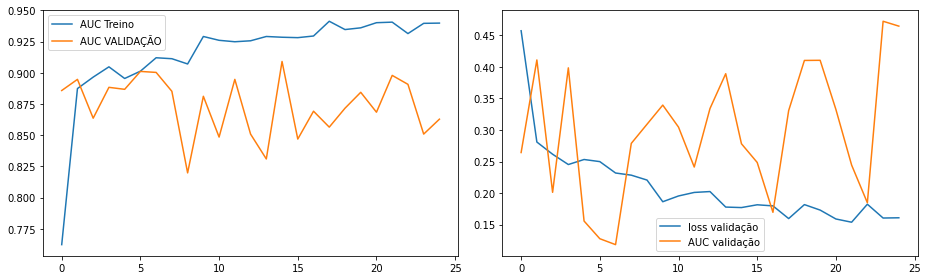

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 5b - 3 dense - SDG

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

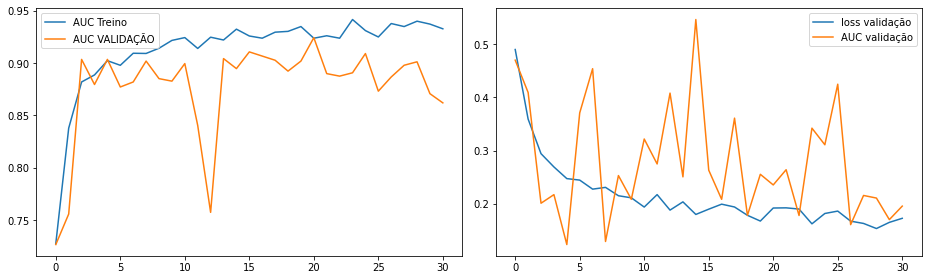

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer
@model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 5b - 5 dense - SGD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

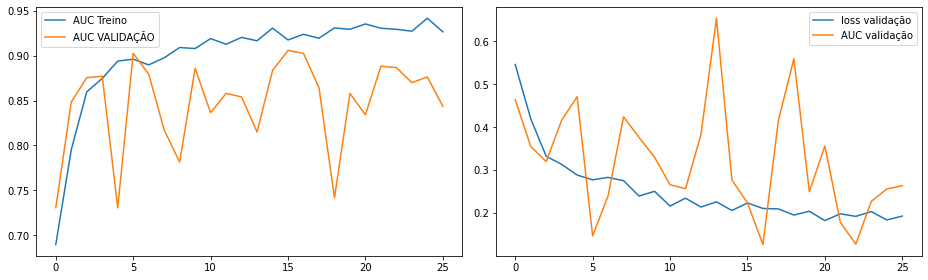

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 4 - 2 dense 1024, 512 COM SGD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

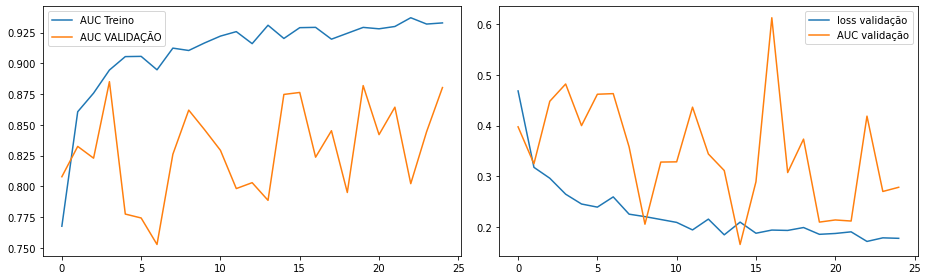

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 6 - 1 dense 256

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1756 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_27 (ZeroPadding2 (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_27[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________

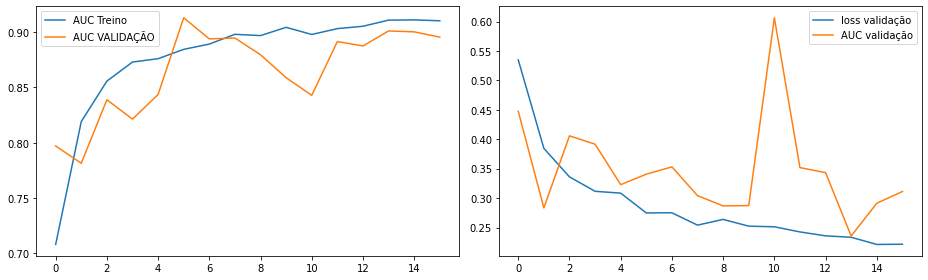

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##ResNet50v2

234553344/234545216 [==============================] - 6s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Epoch 1/100
109/109 [==============================] - 72s 660ms/step - loss: 0.3469 - accuracy: 0.8705 - val_loss: 0.1266 - val_accuracy: 0.8804

Epoch 00001: val_loss improved from inf to 0.12665, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/ResNet152V2-v9-.h5
Epoch 2/100
109/109 [==============================] - 67s 612ms/step - loss: 0.2332 - accuracy: 0.9094 - val_loss: 0.2079 - val_accuracy: 0.9075

Epoch 00002: val_loss did not improve from 0.12665
Epoch 3/100
109/109 [==============================] - 66s 603ms/step - loss: 0.2135 - accuracy: 0.9180 - val_loss: 0.1543 - val_accuracy: 0.9083

Epoch 00003: val_loss did not improve from 0.12665
Epoch 4/100
109/109 [==============================] - 66s 602ms/step - loss: 0.2105 - accuracy: 0.9211 - val_loss: 0.1785 - val_accuracy: 0.9306

Epoch 00004: val_loss did not improve from 0.12665
Epoch 5/100
109/109 [==============================] - 65s 600ms/step - loss: 0.2008 - accuracy: 0.9249 - val_loss: 0.1315

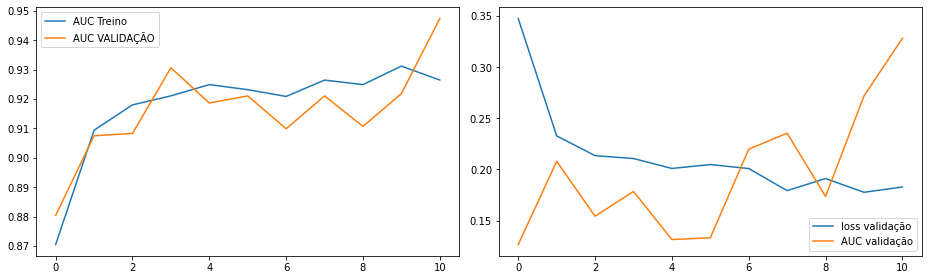

In [0]:
#ResNet152V2
ResNet152V2 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido, 1pb

for layer in ResNet152V2.layers:
  layer.trainable=False

FC = addTopModel(ResNet152V2, num_classes) #MobileNet = bottom_model
model = Model(input=ResNet152V2.input, output=FC) #bottom layers, top layer

#model.summary()

name_model = 'ResNet152V2'+version+'.h5'

checkpoint = ModelCheckpoint(data_dir+'ResNet152V2'+version+'.h5',
                            monitor='val_loss',
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

#confuzin and matrix
#print(classification_report())

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##InceptionResNetv2

219062272/219055592 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Epoch 1/100
109/109 [==============================] - 72s 659ms/step - loss: 0.4546 - accuracy: 0.7707 - val_loss: 0.3588 - val_accuracy: 0.8657

Epoch 00001: val_loss improved from inf to 0.35875, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/InceptionResNetV2-v9-.h5
Epoch 2/100
109/109 [==============================] - 65s 594ms/step - loss: 0.3580 - accuracy: 0.8446 - val_loss: 0.5536 - val_accuracy: 0.8206

Epoch 00002: val_loss did not improve from 0.35875
Epoch 3/100
109/109 [==============================] - 64s 587ms/step - loss: 0.3375 - accuracy: 0.8609 - val_loss: 1.1133 - val_accuracy: 0.8206

Epoch 00003: val_loss did not improve from 0.35875
Epoch 4/100
109/109 [==============================] - 64s 587ms/step - loss: 0.3021 - accuracy: 0.8755 - val_loss: 0.3476 - val_accuracy: 0.8660

Epoch 00004: val_loss improved from 0.35875 to 0.34757, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/InceptionResNetV2-v9-.h5
Epoch 5/100
109/109 

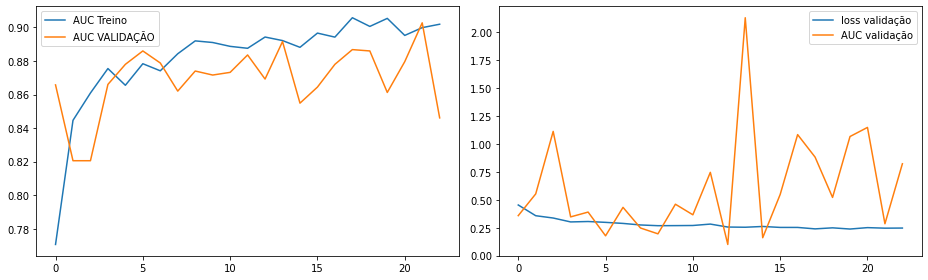

In [0]:
#InceptionResNetV2
InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionResNetV2.layers:
  layer.trainable=False

FC = addTopModel(InceptionResNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionResNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionResNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Inceptionv3

87916544/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Epoch 1/100
109/109 [==============================] - 63s 575ms/step - loss: 0.4444 - accuracy: 0.7902 - val_loss: 0.4664 - val_accuracy: 0.8495

Epoch 00001: val_loss improved from inf to 0.46635, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/InceptionV3-v9-.h5
Epoch 2/100
109/109 [==============================] - 61s 559ms/step - loss: 0.3430 - accuracy: 0.8565 - val_loss: 0.4996 - val_accuracy: 0.7488

Epoch 00002: val_loss did not improve from 0.46635
Epoch 3/100
109/109 [==============================] - 60s 553ms/step - loss: 0.3305 - accuracy: 0.8586 - val_loss: 0.5407 - val_accuracy: 0.7368

Epoch 00003: val_loss did not improve from 0.46635
Epoch 4/100
109/109 [==============================] - 60s 550ms/step - loss: 0.3060 - accuracy: 0.8730 - val_loss: 0.4007 - val_accuracy: 0.8748

Epoch 00004: val_loss improved from 0.46635 to 0.40065, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/InceptionV3-v9-.h5
Epoch 5/100
109/109 [===========

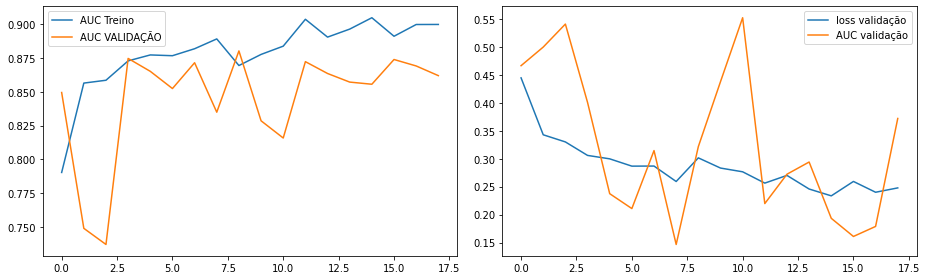

In [0]:
#Inception2
InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionV3.layers:
  layer.trainable=False

FC = addTopModel(InceptionV3, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionV3.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionV3'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##VGG19

80142336/80134624 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Epoch 1/100
109/109 [==============================] - 62s 567ms/step - loss: 0.4458 - accuracy: 0.7728 - val_loss: 0.4523 - val_accuracy: 0.8272

Epoch 00001: val_loss improved from inf to 0.45232, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/VGG19-v9-.h5
Epoch 2/100
109/109 [==============================] - 63s 581ms/step - loss: 0.3707 - accuracy: 0.8395 - val_loss: 0.3515 - val_accuracy: 0.8278

Epoch 00002: val_loss improved from 0.45232 to 0.35149, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/VGG19-v9-.h5
Epoch 3/100
109/109 [==============================] - 63s 577ms/step - loss: 0.3501 - accuracy: 0.8475 - val_loss: 0.2569 - val_accuracy: 0.8732

Epoch 00003: val_loss improved from 0.35149 to 0.25691, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/VGG19-v9-.h5
Epoch 4/100
109/109 [==============================] - 62s 572ms/step - loss: 0.3226 - accuracy: 0.8730 - val_loss: 0.2268 - val_accuracy: 0.8892

Epoch 00004

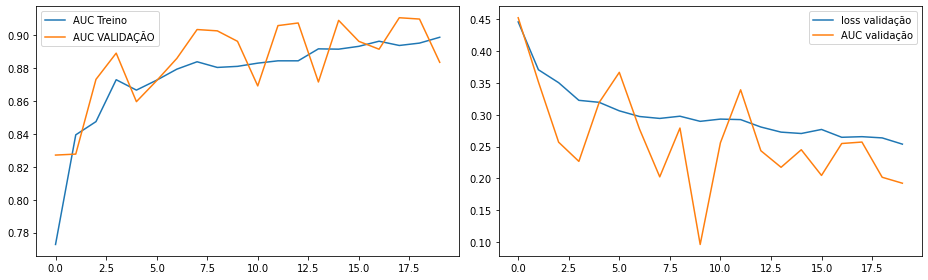

In [0]:
#VGG19
VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in VGG19.layers:
  layer.trainable=False

FC = addTopModel(VGG19, num_classes) #MobileNet = bottom_model
model = Model(input=VGG19.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'VGG19'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##MobileNet

9412608/9406464 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Epoch 1/100
109/109 [==============================] - 60s 551ms/step - loss: 0.3665 - accuracy: 0.8385 - val_loss: 0.4339 - val_accuracy: 0.7052

Epoch 00001: val_loss improved from inf to 0.43392, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/MobileNetV2-v9-.h5
Epoch 2/100
109/109 [==============================] - 60s 549ms/step - loss: 0.2674 - accuracy: 0.8893 - val_loss: 0.4245 - val_accuracy: 0.7185

Epoch 00002: val_loss improved from 0.43392 to 0.42447, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/MobileNetV2-v9-.h5
Epoch 3/100
109/109 [==============================] - 59s 545ms/step - loss: 0.2364 - accuracy: 0.9040 - val_loss: 0.3044 - val_accuracy: 0.7456

Epoch 00003: val_loss improved from 0.42447 to 0.30444, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/MobileNetV2-v9-.h5
Epoch 4/100
109/109 [==============================] - 59s 546ms/step - loss: 0.2428 - accuracy: 0.9069 - val_loss: 0.4893 - val_accuracy: 0

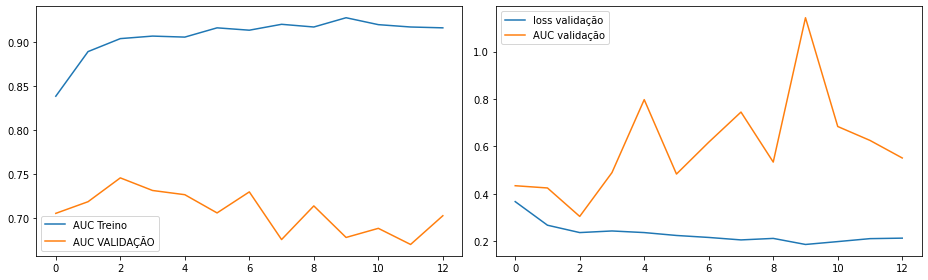

In [0]:
#MobileNetV2
MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in MobileNetV2.layers:
  layer.trainable=False

FC = addTopModel(MobileNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=MobileNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'MobileNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

In [0]:
#NASNetLarge
NASNetLarge = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in NASNetLarge.layers:
  layer.trainable=False

FC = addTopModel(NASNetLarge, num_classes) #MobileNet = bottom_model
model = Model(input=NASNetLarge.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('NASNetLarge'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Xcepiton

##CheXNet

###Download do modelo

In [0]:
%%shell

cd '/content/drive/My Drive/UNICAMP/databases/chexnet'
git clone https://github.com/jrzech/reproduce-chexnet.git

Cloning into 'reproduce-chexnet'...
remote: Enumerating objects: 668, done.
remote: Total 668 (delta 0), reused 0 (delta 0), pack-reused 668
Receiving objects: 100% (668/668), 272.61 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (638/638), done.


###Model

In [0]:
#import
import torch
import pandas as pd
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import sklearn
import sklearn.metrics as sklm
from torch.autograd import Variable
import numpy as np
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
from skimage import io, transform
import time
from shutil import copyfile
from shutil import rmtree
import csv
from copy import deepcopy
import scipy as sp
from pylab import *
import seaborn as sns
from matplotlib.pyplot import show

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

use_gpu = torch.cuda.is_available()
gpu_count = torch.cuda.device_count()
print("Available GPU count:" + str(gpu_count))

#DEFS
class CXRDataset(Dataset):

    def __init__(
            self,
            path_to_images,
            fold,
            transform=None,
            sample=0,
            finding="any",
            starter_images=False):

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv("/content/drive/My Drive/UNICAMP/databases/chexnet/reproduce-chexnet/nih_labels.csv")
        self.df = self.df[self.df['fold'] == fold]

        if(starter_images):
            starter_images = pd.read_csv("starter_images.csv")
            self.df=pd.merge(left=self.df,right=starter_images, how="inner",on="Image Index")

        # can limit to sample, useful for testing
        # if fold == "train" or fold =="val": sample=500
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(sample)

        if not finding == "any":  # can filter for positive findings of the kind described; useful for evaluation
            if finding in self.df.columns:
                if len(self.df[self.df[finding] == 1]) > 0:
                    self.df = self.df[self.df[finding] == 1]
                else:
                    print("No positive cases exist for "+LABEL+", returning all unfiltered cases")
            else:
                print("cannot filter on finding " + finding +
                      " as not in data - please check spelling")

        self.df = self.df.set_index("Image Index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']
        RESULT_PATH = "results/"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
             # can leave zero if zero, else make one
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])

def make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model

    Args:
        data_transforms: torchvision transforms to preprocess raw images; same as validation transforms
        model: densenet-121 from torchvision previously fine tuned to training data
        PATH_TO_IMAGES: path at which NIH images can be found
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    # calc preds in batches of 16, can reduce if your GPU has less RAM
    BATCH_SIZE = 16

    # set model to eval mode; required for proper predictions given use of batchnorm
    model.train(False)

    # create dataloader
    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold="test",
        transform=data_transforms['val'])
    dataloader = torch.utils.data.DataLoader(
        dataset, BATCH_SIZE, shuffle=False, num_workers=8)
    size = len(dataset)

    # create empty dfs
    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])

    # iterate over dataloader
    for i, data in enumerate(dataloader):

        inputs, labels, _ = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape

        outputs = model(inputs)
        probs = outputs.cpu().data.numpy()

        # get predictions and true values for each item in batch
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(dataset.PRED_LABEL)):
                thisrow["prob_" + dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))

    auc_df = pd.DataFrame(columns=["label", "auc"])

    # calc AUCs
    for column in true_df:

        if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
                    continue
        actual = true_df[column]
        pred = pred_df["prob_" + column]
        thisrow = {}
        thisrow['label'] = column
        thisrow['auc'] = np.nan
        try:
            thisrow['auc'] = sklm.roc_auc_score(
                actual.as_matrix().astype(int), pred.as_matrix())
        except BaseException:
            print("can't calculate auc for " + str(column))
        auc_df = auc_df.append(thisrow, ignore_index=True)

    pred_df.to_csv("results/preds.csv", index=False)
    auc_df.to_csv("results/aucs.csv", index=False)
    return pred_df, auc_df

def checkpoint(model, best_loss, epoch, LR):
    """
    Saves checkpoint of torchvision model during training.

    Args:
        model: torchvision model to be saved
        best_loss: best val loss achieved so far in training
        epoch: current epoch of training
        LR: current learning rate in training
    Returns:
        None
    """

    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, 'results/checkpoint')


def train_model(
        model,
        criterion,
        optimizer,
        LR,
        num_epochs,
        dataloaders,
        dataset_sizes,
        weight_decay):
    """
    Fine tunes torchvision model to NIH CXR data.

    Args:
        model: torchvision model to be finetuned (densenet-121 in this case)
        criterion: loss criterion (binary cross entropy loss, BCELoss)
        optimizer: optimizer to use in training (SGD)
        LR: learning rate
        num_epochs: continue training up to this many epochs
        dataloaders: pytorch train and val dataloaders
        dataset_sizes: length of train and val datasets
        weight_decay: weight decay parameter we use in SGD with momentum
    Returns:
        model: trained torchvision model
        best_epoch: epoch on which best model val loss was obtained

    """
    since = time.time()

    start_epoch = 1
    best_loss = 999999
    best_epoch = -1
    last_train_loss = -1

    # iterate over epochs
    for epoch in range(start_epoch, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # set model to train or eval mode based on whether we are in train or
        # val; necessary to get correct predictions given batchnorm
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0

            i = 0
            total_done = 0
            # iterate over all data in train/val dataloader:
            for data in dataloaders[phase]:
                i += 1
                inputs, labels, _ = data
                batch_size = inputs.shape[0]
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda()).float()
                outputs = model(inputs)

                # calculate gradient and update parameters in train phase
                optimizer.zero_grad()
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * batch_size

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'train':
                last_train_loss = epoch_loss

            print(phase + ' epoch {}:loss {:.4f} with data size {}'.format(
                epoch, epoch_loss, dataset_sizes[phase]))

            # decay learning rate if no val loss improvement in this epoch

            if phase == 'val' and epoch_loss > best_loss:
                print("decay loss from " + str(LR) + " to " +
                      str(LR / 10) + " as not seeing improvement in val loss")
                LR = LR / 10
                # create new optimizer with lower learning rate
                optimizer = optim.SGD(
                    filter(
                        lambda p: p.requires_grad,
                        model.parameters()),
                    lr=LR,
                    momentum=0.9,
                    weight_decay=weight_decay)
                print("created new optimizer with LR " + str(LR))

            # checkpoint model if has best val loss yet
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                checkpoint(model, best_loss, epoch, LR)

            # log training and validation loss over each epoch
            if phase == 'val':
                with open("results/log_train", 'a') as logfile:
                    logwriter = csv.writer(logfile, delimiter=',')
                    if(epoch == 1):
                        logwriter.writerow(["epoch", "train_loss", "val_loss"])
                    logwriter.writerow([epoch, last_train_loss, epoch_loss])

        total_done += batch_size
        if(total_done % (100 * batch_size) == 0):
            print("completed " + str(total_done) + " so far in epoch")

        # break if no val loss improvement in 3 epochs
        if ((epoch - best_epoch) >= 3):
            print("no improvement in 3 epochs, break")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights to return
    checkpoint_best = torch.load('results/checkpoint')
    model = checkpoint_best['model']

    return model, best_epoch


def train_cnn(PATH_TO_IMAGES, LR, WEIGHT_DECAY):
    """
    Train torchvision model to NIH data given high level hyperparameters.

    Args:
        PATH_TO_IMAGES: path to NIH images
        LR: learning rate
        WEIGHT_DECAY: weight decay parameter for SGD

    Returns:
        preds: torchvision model predictions on test fold with ground truth for comparison
        aucs: AUCs for each train,test tuple

    """
    NUM_EPOCHS = 100
    BATCH_SIZE = 16

    try:
        rmtree('results/')
    except BaseException:
        pass  # directory doesn't yet exist, no need to clear it
    os.makedirs("results/")

    # use imagenet mean,std for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    N_LABELS = 14  # we are predicting 14 labels

    # load labels
    df = pd.read_csv("/content/drive/My Drive/UNICAMP/databases/chexnet/reproduce-chexnet/nih_labels.csv", index_col=0)

    # define torchvision transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Scale(224),
            # because scale doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    # create train/val dataloaders
    transformed_datasets = {}
    transformed_datasets['train'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='train',
        transform=data_transforms['train'])
    transformed_datasets['val'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='val',
        transform=data_transforms['val'])

    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(
        transformed_datasets['train'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)
    dataloaders['val'] = torch.utils.data.DataLoader(
        transformed_datasets['val'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)

    # please do not attempt to train without GPU as will take excessively long
    if not use_gpu:
        raise ValueError("Error, requires GPU")
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    # add final layer with # outputs in same dimension of labels with sigmoid
    # activation
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, N_LABELS), nn.Sigmoid())

    # put model on GPU
    model = model.cuda()

    # define criterion, optimizer for training
    criterion = nn.BCELoss()
    optimizer = optim.SGD(
        filter(
            lambda p: p.requires_grad,
            model.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY)
    dataset_sizes = {x: len(transformed_datasets[x]) for x in ['train', 'val']}

    # train model
    model, best_epoch = train_model(model, criterion, optimizer, LR, num_epochs=NUM_EPOCHS,
                                    dataloaders=dataloaders, dataset_sizes=dataset_sizes, weight_decay=WEIGHT_DECAY)

    # get preds and AUCs on test fold
    preds, aucs = E.make_pred_multilabel(
        data_transforms, model, PATH_TO_IMAGES)

    return preds, aucs

def calc_cam(x, label, model):
    """
    function to generate a class activation map corresponding to a torch image tensor

    Args:
        x: the 1x3x224x224 pytorch tensor file that represents the NIH CXR
        label:user-supplied label you wish to get class activation map for; must be in FINDINGS list
        model: densenet121 trained on NIH CXR data

    Returns:
        cam_torch: 224x224 torch tensor containing activation map
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    if label not in FINDINGS:
        raise ValueError(
            str(label) +
            "is an invalid finding - please use one of " +
            str(FINDINGS))

    # find index for label; this corresponds to index from output of net
    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == label))

    # define densenet_last_layer class so we can get last 1024 x 7 x 7 output
    # of densenet for class activation map
    class densenet_last_layer(torch.nn.Module):
        def __init__(self, model):
            super(densenet_last_layer, self).__init__()
            self.features = torch.nn.Sequential(
                *list(model.children())[:-1]
            )

        def forward(self, x):
            x = self.features(x)
            x = torch.nn.functional.relu(x, inplace=True)
            return x

    # instantiate cam model and get output
    model_cam = densenet_last_layer(model)
    x = torch.autograd.Variable(x)
    y = model_cam(x)
    y = y.cpu().data.numpy()
    y = np.squeeze(y)

    # pull weights corresponding to the 1024 layers from model
    weights = model.state_dict()['classifier.0.weight']
    weights = weights.cpu().numpy()

    bias = model.state_dict()['classifier.0.bias']
    bias = bias.cpu().numpy()

    # can replicate bottleneck and probability calculation here from last_layer network and params from
    # original network to ensure that reconstruction is accurate -- commented out as previously checked

    #model_bn = deepcopy(model)
    #new_classifier = torch.nn.Sequential(*list(model_bn.classifier.children())[:-2])
    #model_bn.classifier = new_classifier
    #bn=model_bn(x)
    #recreate=0
    #bottleneck = []
    #for k in range(0,1024):
    #    avg_value = np.mean(y[k,:,:])# over the 7x7 grid
    #    bottleneck.append(avg_value)
    #    recreate = recreate+weights[label_index,k]*avg_value
    #recreate = recreate + bias[label_index]
    #recreate = 1/(1+math.exp(-recreate))
    #print("recalc:")
    #print(recreate)
    #print("original:")
    #print(model(x).data.numpy()[0][label_index])

    # create 7x7 cam
    cam = np.zeros((7, 7, 1))
    for i in range(0, 7):
        for j in range(0, 7):
            for k in range(0, 1024):
                cam[i, j] += y[k, i, j] * weights[label_index, k]
    cam+=bias[label_index]

    #make cam into local region probabilities with sigmoid

    cam=1/(1+np.exp(-cam))

    label_baseline_probs={
        'Atelectasis':0.103,
        'Cardiomegaly':0.025,
        'Effusion':0.119,
        'Infiltration':0.177,
        'Mass':0.051,
        'Nodule':0.056,
        'Pneumonia':0.012,
        'Pneumothorax':0.047,
        'Consolidation':0.042,
        'Edema':0.021,
        'Emphysema':0.022,
        'Fibrosis':0.015,
        'Pleural_Thickening':0.03,
        'Hernia':0.002
    }

    #normalize by baseline probabilities
    cam = cam/label_baseline_probs[label]

    #take log
    cam = np.log(cam)

    return cam

def load_data(
        PATH_TO_IMAGES,
        LABEL,
        PATH_TO_MODEL,
        POSITIVE_FINDINGS_ONLY,
        STARTER_IMAGES):
    """
    Loads dataloader and torchvision model

    Args:
        PATH_TO_IMAGES: path to NIH CXR images
        LABEL: finding of interest (must exactly match one of FINDINGS defined below or will get error)
        PATH_TO_MODEL: path to downloaded pretrained model or your own retrained model
        POSITIVE_FINDINGS_ONLY: dataloader will show only examples + for LABEL pathology if True, otherwise shows positive
                                and negative examples if false

    Returns:
        dataloader: dataloader with test examples to show
        model: fine tuned torchvision densenet-121
    """

    checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
    model = checkpoint['model']
    del checkpoint
    model.cpu()

    # build dataloader on test
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    data_transform = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if not POSITIVE_FINDINGS_ONLY:
        finding = "any"
    else:
        finding = LABEL

    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='test',
        transform=data_transform,
        finding=finding,
        starter_images=STARTER_IMAGES)

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=1)

    return iter(dataloader), model


def show_next(dataloader, model, LABEL):
    """
    Plots CXR, activation map of CXR, and shows model probabilities of findings

    Args:
        dataloader: dataloader of test CXRs
        model: fine-tuned torchvision densenet-121
        LABEL: finding we're interested in seeing heatmap for
    Returns:
        None (plots output)
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == LABEL))

    # get next iter from dataloader
    try:
        inputs, labels, filename = next(dataloader)
    except StopIteration:
        print("All examples exhausted - rerun cells above to generate new examples to review")
        return None

    # get cam map
    original = inputs.clone()
    raw_cam = calc_cam(inputs, LABEL, model)

    # create predictions for label of interest and all labels
    pred = model(torch.autograd.Variable(original.cpu())).data.numpy()[0]
    predx = ['%.3f' % elem for elem in list(pred)]

    fig, (showcxr,heatmap) =plt.subplots(ncols=2,figsize=(14,5))

    hmap = sns.heatmap(raw_cam.squeeze(),
            cmap = 'viridis',
            alpha = 0.3, # whole heatmap is translucent
            annot = True,
            zorder = 2,square=True,vmin=-5,vmax=5
            )

    cxr=inputs.numpy().squeeze().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)

    hmap.imshow(cxr,
          aspect = hmap.get_aspect(),
          extent = hmap.get_xlim() + hmap.get_ylim(),
          zorder = 1) #put the map under the heatmap
    hmap.axis('off')
    hmap.set_title("P("+LABEL+")="+str(predx[label_index]))

    showcxr.imshow(cxr)
    showcxr.axis('off')
    showcxr.set_title(filename[0])
    plt.savefig(str(LABEL+"_P"+str(predx[label_index])+"_file_"+filename[0]))
    plt.show()



    preds_concat=pd.concat([pd.Series(FINDINGS),pd.Series(predx),pd.Series(labels.numpy().astype(bool)[0])],axis=1)
    preds = pd.DataFrame(data=preds_concat)
    preds.columns=["Finding","Predicted Probability","Ground Truth"]
    preds.set_index("Finding",inplace=True)
    preds.sort_values(by='Predicted Probability',inplace=True,ascending=False)

    return preds

Available GPU count:1


In [0]:
############# FIM DAS DEFS ################

#CONTSTANTS
# you will need to customize PATH_TO_IMAGES to where you have uncompressed
# NIH images
PATH_TO_IMAGES = "/content/drive/My Drive/UNICAMP/databases/chexnet/reproduce-chexnet/starter_images"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
preds, aucs = train_cnn(PATH_TO_IMAGES, LEARNING_RATE, WEIGHT_DECAY)

use_gpu = torch.cuda.is_available()
gpu_count = torch.cuda.device_count()
print("Available GPU count:" + str(gpu_count))

#CheXNet_2

In [0]:
%%shell

cd '/content/drive/My Drive/UNICAMP/databases/chexnet'
git clone https://github.com/lschirmer/covid-19-chexnet.git

Cloning into 'covid-19-chexnet'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 157 (delta 36), reused 105 (delta 14), pack-reused 0
Receiving objects: 100% (157/157), 37.96 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (73/73), done.


In [0]:
!ping 8.8.8.8

/bin/bash: ping: command not found


In [0]:
import torch
import pandas as pd
import cxr_dataset as CXR
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import sklearn
import sklearn.metrics as sklm
from torch.autograd import Variable
import numpy as np


def make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model

    Args:
        data_transforms: torchvision transforms to preprocess raw images; same as validation transforms
        model: densenet-121 from torchvision previously fine tuned to training data
        PATH_TO_IMAGES: path at which NIH images can be found
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    # calc preds in batches of 16, can reduce if your GPU has less RAM
    BATCH_SIZE = 16

    # set model to eval mode; required for proper predictions given use of batchnorm
    model.train(False)

    # create dataloader
    dataset = CXR.CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold="test",
        transform=data_transforms['val'])
    dataloader = torch.utils.data.DataLoader(
        dataset, BATCH_SIZE, shuffle=False, num_workers=8)
    size = len(dataset)

    # create empty dfs
    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])

    # iterate over dataloader
    for i, data in enumerate(dataloader):

        inputs, labels, _ = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape

        outputs = model(inputs)
        probs = outputs.cpu().data.numpy()

        # get predictions and true values for each item in batch
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(dataset.PRED_LABEL)):
                thisrow["prob_" + dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))

    auc_df = pd.DataFrame(columns=["label", "auc"])

    # calc AUCs
    for column in true_df:

        if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
                    continue
        actual = true_df[column]
        pred = pred_df["prob_" + column]
        thisrow = {}
        thisrow['label'] = column
        thisrow['auc'] = np.nan
        try:
            thisrow['auc'] = sklm.roc_auc_score(
                actual.as_matrix().astype(int), pred.as_matrix())
        except BaseException:
            print("can't calculate auc for " + str(column))
        auc_df = auc_df.append(thisrow, ignore_index=True)

    pred_df.to_csv("results/preds.csv", index=False)
    auc_df.to_csv("results/aucs.csv", index=False)
    return pred_df, auc_df


In [0]:
#Xception
Xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in Xception.layers:
  layer.trainable=False

FC = addTopModel(Xception, num_classes) #MobileNet = bottom_model
model = Model(input=Xception.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'Xception'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

83689472/83683744 [==============================] - 4s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 67s 580ms/step - loss: 0.9535 - accuracy: 0.5247 - val_loss: 0.8555 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.85552, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/Xception-v6-.h5
Epoch 2/100
116/116 [==============================] - 65s 557ms/step - loss: 0.8526 - accuracy: 0.6245 - val_loss: 0.6441 - val_accuracy: 0.5367

Epoch 00002: val_loss improved from 0.85552 to 0.64410, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/Xception-v6-.h5
Epoch 3/100
116/116 [==============================] - 62s 537ms/step - loss: 0.8074 - accuracy: 0.6679 - val_loss: 0.8354 - val_accuracy: 0.5657

Epoch 00003: val_loss did not improve from 0.64410
Epoch 4/100
116/116 [==============================] - 62s 532ms/step - loss: 0.7918 - accuracy: 0.6886 - val_loss: 0.6802 - val_accuracy: 0.5301

Epoch 00004: val_loss did not improve from 0.64410
Epoch 5/100
116/116 [=================

KeyboardInterrupt: ignored

-----------------
-----------------
-----------------
-----------------


-----------------
-----------------
-----------------


#Resultados

**Teste 6 - 1 dense 256 - Com SGD**
Epoch 21/100

loss: 0.2230 - accuracy: 0.9092 - val_loss: 0.0968 - val_accuracy: 0.8768


-------------------

**Teste 5 - 6 dense decrescente - Com SGD**
Epoch 4/100

loss: 0.2733 - accuracy: 0.8897 - val_loss: 0.1552 - val_accuracy: 0.8797

loss: 0.1740 - accuracy: 0.9392 - val_loss: 0.2047 - val_accuracy: 0.8901


-------------------
 
**Teste 4 - 2 dense 1024, 512 - COM SGD**
Epoch 4/100

loss: 0.2733 - accuracy: 0.8897 - val_loss: 0.1552 - val_accuracy: 0.8797

-------------------

**Teste 3 - 6 dense decrescentes - ADAM** 
Epoch 25/100

loss: 0.1679 - accuracy: 0.9416 - val_loss: 0.1106 - val_accuracy: 0.8641


-------------------
 
**Teste 2 - Dense 256 - com ADAM**
Epoch 11/100

loss: 0.1912 - accuracy: 0.9237 - val_loss: 0.1596 - val_accuracy: 0.8953

loss: 0.1740 - accuracy: 0.9392 - val_loss: 0.2047 - val_accuracy: 0.8901 #melhor deste teste

-------------------
 
**Teste 1 - 1 dense de 1024**
Epoch 10/100

loss: 0.2075 - accuracy: 0.9163 - val_loss: 0.0813 - val_accuracy: 0.8797

loss: 0.1720 - accuracy: 0.9325 - val_loss: 0.5832 - val_accuracy: 0.8790 #melhor de todas as epocas


-------------------
 

In [0]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))